In [1]:
import numpy as np
import pandas as pd

In [2]:
#read train csv and split
delimiter="\t"
train_df = pd.read_csv('train.csv',delimiter="\t").astype(str)

train_df.head(10)

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0
5,"When Reese Witherspoon was 17, she had already...",0
6,It’s official! WAGS Miami stars Ashley Nicole ...,0
7,"On March 24, 2018, one month and ten days afte...",1
8,A mosque in Georgia is under fire after they s...,1
9,Scott Disick is sticking up for Khloe Kardashi...,1


In [3]:
#find str in label
fliter1 = (train_df['label']!= '0')
fliter2 = (train_df['label']!= '1')
train_df[fliter1 & fliter2]

,text,label
1615,content,label


In [4]:
train_df= train_df.drop(index=1615)

In [5]:
delimiter="\t"
test_text_df = pd.read_csv('test.csv',delimiter="\t").astype(str)

test_text_df.head(10)

,id,text
0,2,The 2017 Teen Choice Awards ceremony was held ...
1,3,"The concert, part of “The Joshua Tree Tour,” w..."
2,4,Selena Gomez refuses to talk to her mother abo...
3,5,This is worse than a lump of coal in your stoc...
4,6,Luann De Lesseps is going to rehab after her a...
5,7,Diamond's Weinstein meets a grisly end Saved ...
6,8,"After 13 years, Ashlee Simpson-Ross is once ag..."
7,9,"In honor of their 70th wedding anniversary, th..."
8,10,Demi Lovato has made no secret that she's a mi...
9,11,Twitter Caught Leaking Donald Trump's Private ...


In [6]:
test_label_df=pd.read_csv('sample_submission.csv')
test_label_df.head()

,id,label
0,2,1
1,3,1
2,4,0
3,5,0
4,6,0


In [7]:
test_label_df.id = test_label_df.id.astype('O')
test_label_df.label = test_label_df.label.astype('O')

In [8]:
test_df = pd.merge(test_text_df, test_label_df ,how='left', on='id')
test_df.label = test_label_df.label

In [9]:
test_df.head(5)

,id,text,label
0,2,The 2017 Teen Choice Awards ceremony was held ...,1
1,3,"The concert, part of “The Joshua Tree Tour,” w...",1
2,4,Selena Gomez refuses to talk to her mother abo...,0
3,5,This is worse than a lump of coal in your stoc...,0
4,6,Luann De Lesseps is going to rehab after her a...,0


In [10]:
from gensim.models.word2vec import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

In [11]:
#remove stopwords in gensim
train_df['text'] = train_df['text'].apply(lambda x: remove_stopwords(" ".join(x)))
test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(" ".join(x)))

In [15]:
model = Word2Vec(train_df['text'], size=100, window=5, min_count=5)

In [16]:
#把訓練好的 Word2Vec 模型存起來
model.save('word2vec.model')

In [12]:
w2v_model = Word2Vec.load('word2vec.model')
#生成一個Shape為 (總詞數 + 1, 詞向量維度) 的零矩陣作為權重矩陣
embedding_matrix = np.zeros((len(w2v_model.wv.vocab.items()) + 1, w2v_model.vector_size))
#生成一張空的table（待會就能利用table直接把詞給轉成index）
word2idx = {}
#從詞向量模型中，取出所有的詞與詞向量
vocab_list = [(word, w2v_model.wv[word]) for word, _ in w2v_model.wv.vocab.items()]
for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    #從第 1 列開始，把詞向量塞進權重矩陣裡（一列一列往下堆疊）
    embedding_matrix[i + 1] = vec
    #詞向量塞進第 n 列時，就在 table 裡加入 { 詞 → n } 的關係
    word2idx[word] = i + 1

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense,Dropout

Using TensorFlow backend.


In [14]:
#用權重矩陣生成一份Embedding layer
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

In [15]:
#利用剛才建立的table，把資料中的所有詞都轉換成index
#用try, except的方式，如果在table中找不到詞時，那就填0上去
def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)

In [19]:
#pad_sequences() 會把太長的 input 給截短，太短的 input 則填上一堆 0 來補足長度
PADDING_LENGTH = 500
X = text_to_index(train_df.text)
X = pad_sequences(X, maxlen=PADDING_LENGTH)
print("Shape:", X.shape)
print("Sample:", X[0])

Shape: (4986, 500)
Sample: [222 132 222 169 222 259 222 165 222 165 222 186 222 185 222 150 222 135
 222 185 222 186 222 108 222 150 222 230 222 264 222 115 222 115 222 264
 222 185 222 124 222 260 222 112 222 264 222  80 222 185 222 230 222 200
 222 186 222 115 222 135 222 115 222 186 222 115 222 185 222 169 222  47
 222 185 222 150 222  76 222 260 222  92 222 186 222 200 222 135 222 185
 222 150 222 230 222 264 222 230 222 115 222 185 222 186 222 186 222  96
 222 115 222 259 222 127 222 186 222  80 222  78 222 264 222 264 222 165
 222 230 222 124 222  61 222 169 222  76 222 259 222 169 222  78 222 136
 222 264 222 259 222 186 222 124 222  77 222 136 222 186 222 136 222 169
 222 200 222  29 222  80 222 136 222 186 222 136 222 169 222 200 222 259
 222 169 222 112 222 259 222 149 222  29 222 185 222 185 222  96 222 185
 222 169 222  76 222 108 222 212 222  43 222 230 222 115 222 124 222 150
 222 135 222 115 222 185 222  47 222 185 222 169 222 150 222 230 222 104
 222 259 222 104 222  43

In [20]:
Y = to_categorical(train_df.label)
print("Shape:", Y.shape)
print("Sample:", Y[0])

Shape: (4986, 2)
Sample: [0. 1.]


In [21]:
def RNN_model():
    RNN_model = Sequential()
    RNN_model.add(embedding_layer)
    RNN_model.add(Dropout(0.5))
    RNN_model.add(GRU(16))    
    RNN_model.add(Dense(100, activation='relu'))
    RNN_model.add(Dense(100, activation='relu'))
    RNN_model.add(Dropout(0.5))
    RNN_model.add(Dense(2, activation='sigmoid'))
    
    RNN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return RNN_model

In [22]:
RNNmodel = RNN_model()
RNNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         26700     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total para

In [25]:
import matplotlib.pyplot as plt

Train on 3988 samples, validate on 998 samples
Epoch 1/30
3988/3988 [==============================] - 34s 8ms/step - loss: 0.6301 - acc: 0.6437 - val_loss: 0.6614 - val_acc: 0.6222
Epoch 2/30
3988/3988 [==============================] - 33s 8ms/step - loss: 0.6322 - acc: 0.6357 - val_loss: 0.6571 - val_acc: 0.6253
Epoch 3/30
3988/3988 [==============================] - 34s 8ms/step - loss: 0.6262 - acc: 0.6419 - val_loss: 0.6604 - val_acc: 0.6082
Epoch 4/30
3988/3988 [==============================] - 33s 8ms/step - loss: 0.6280 - acc: 0.6439 - val_loss: 0.6587 - val_acc: 0.6062
Epoch 5/30
3988/3988 [==============================] - 33s 8ms/step - loss: 0.6289 - acc: 0.6357 - val_loss: 0.6643 - val_acc: 0.6152
Epoch 6/30
3988/3988 [==============================] - 33s 8ms/step - loss: 0.6272 - acc: 0.6329 - val_loss: 0.6608 - val_acc: 0.6132
Epoch 7/30
3988/3988 [==============================] - 33s 8ms/step - loss: 0.6285 - acc: 0.6472 - val_loss: 0.6679 - val_acc: 0.6022
Epoch 8/

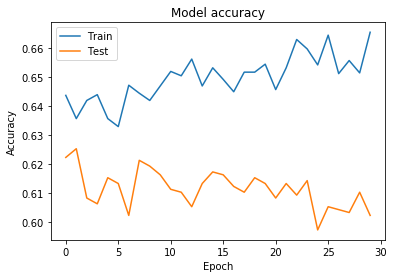

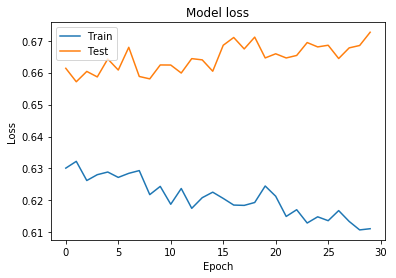

In [28]:
history = RNNmodel.fit(x=X, y=Y, validation_split=0.2, epochs=30, batch_size=32)

# 繪製訓練&驗證的acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 繪製訓練&驗證的loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
# 將訓練好的model儲存成json及h5檔
import json
RNNmodel_json = RNNmodel.to_json()
with open("RNN_model_trained.json", "w") as json_file:
    json.dump(RNN_model_json, json_file)
RNNmodel.save("RNN_model_trained.h5")

In [33]:
from keras.layers.recurrent import LSTM

In [34]:
def LSTM_model():
    LSTM_model = Sequential()
    LSTM_model.add(embedding_layer)
    LSTM_model.add(Dropout(0.5))
    LSTM_model.add(LSTM(32))    
    LSTM_model.add(Dense(100, activation='relu'))
    LSTM_model.add(Dense(100, activation='relu'))
    LSTM_model.add(Dropout(0.5))
    LSTM_model.add(Dense(2, activation='sigmoid'))
    
    LSTM_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return LSTM_model

In [35]:
LSTM_model = LSTM_model()
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         26700     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total para

Train on 3988 samples, validate on 998 samples
Epoch 1/120
3988/3988 [==============================] - 45s 11ms/step - loss: 0.6761 - acc: 0.5918 - val_loss: 0.6760 - val_acc: 0.5922
Epoch 2/120
3988/3988 [==============================] - 49s 12ms/step - loss: 0.6748 - acc: 0.5980 - val_loss: 0.6713 - val_acc: 0.5922
Epoch 3/120
3988/3988 [==============================] - 48s 12ms/step - loss: 0.6704 - acc: 0.5975 - val_loss: 0.6705 - val_acc: 0.5912
Epoch 4/120
3988/3988 [==============================] - 45s 11ms/step - loss: 0.6702 - acc: 0.5943 - val_loss: 0.6749 - val_acc: 0.5872
Epoch 5/120
3988/3988 [==============================] - 44s 11ms/step - loss: 0.6684 - acc: 0.5958 - val_loss: 0.6685 - val_acc: 0.5952
Epoch 6/120
3988/3988 [==============================] - 45s 11ms/step - loss: 0.6643 - acc: 0.5965 - val_loss: 0.6685 - val_acc: 0.5972
Epoch 7/120
3988/3988 [==============================] - 46s 12ms/step - loss: 0.6639 - acc: 0.6033 - val_loss: 0.6650 - val_acc: 0

3988/3988 [==============================] - 43s 11ms/step - loss: 0.5754 - acc: 0.6928 - val_loss: 0.6957 - val_acc: 0.6232
Epoch 61/120
3988/3988 [==============================] - 42s 11ms/step - loss: 0.5668 - acc: 0.7051 - val_loss: 0.7012 - val_acc: 0.6042
Epoch 62/120
3988/3988 [==============================] - 42s 11ms/step - loss: 0.5672 - acc: 0.6958 - val_loss: 0.7048 - val_acc: 0.6263
Epoch 63/120
3988/3988 [==============================] - 42s 11ms/step - loss: 0.5703 - acc: 0.6896 - val_loss: 0.6823 - val_acc: 0.6162
Epoch 64/120
3988/3988 [==============================] - 42s 10ms/step - loss: 0.5648 - acc: 0.6908 - val_loss: 0.6796 - val_acc: 0.6202
Epoch 65/120
3988/3988 [==============================] - 43s 11ms/step - loss: 0.5628 - acc: 0.7031 - val_loss: 0.6868 - val_acc: 0.6313
Epoch 66/120
3988/3988 [==============================] - 42s 10ms/step - loss: 0.5626 - acc: 0.6911 - val_loss: 0.7060 - val_acc: 0.6242
Epoch 67/120
3988/3988 [=======================

3988/3988 [==============================] - 41s 10ms/step - loss: 0.4853 - acc: 0.7440 - val_loss: 0.7933 - val_acc: 0.6152
Epoch 120/120
3988/3988 [==============================] - 43s 11ms/step - loss: 0.4862 - acc: 0.7525 - val_loss: 0.8118 - val_acc: 0.6212


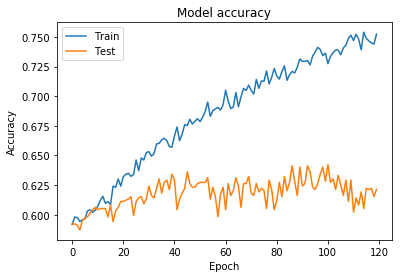

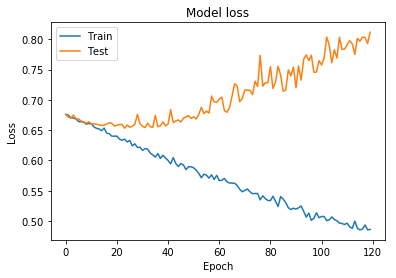

In [36]:
history = LSTM_model.fit(x=X, y=Y, validation_split=0.2, epochs=120, batch_size=32)

# 繪製訓練&驗證的acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM_Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 繪製訓練&驗證的loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM_Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# 將訓練好的model儲存成json及h5檔
import json
LSTM_model_json = LSTM_model.to_json()
with open("LSTM_model_trained.json", "w") as json_file:
    json.dump(LSTM_model_json, json_file)
LSTM_model.save("LSTM_model_trained.h5")

In [38]:
X_test = text_to_index(test_df.text)
X_test = pad_sequences(X_test, maxlen=PADDING_LENGTH)

In [39]:
Y_RNNpreds = RNNmodel.predict(X_test)
print("Shape:", Y_RNNpreds.shape)
print("Sample:", Y_RNNpreds[0])

Shape: (1247, 2)
Sample: [0.8947998 0.5724863]


In [40]:
Y_LSTMpreds = LSTM_model.predict(X_test)
print("Shape:", Y_LSTMpreds.shape)
print("Sample:", Y_LSTMpreds[0])

Shape: (1247, 2)
Sample: [0.6552127  0.45874384]


In [41]:
#用 np.argmax() 取出每筆預測值中機率最高的 category作為我們的最終答案
Y_RNNpreds_label = np.argmax(Y_RNNpreds, axis=1)
print("Shape:", Y_RNNpreds_label.shape)
print("Sample:", Y_RNNpreds_label[0])
print("ground truth:", test_df.label[0])

Shape: (1247,)
Sample: 0
ground truth: 1


In [42]:
Y_LSTMpreds_label = np.argmax(Y_LSTMpreds, axis=1)
print("Shape:", Y_LSTMpreds_label.shape)
print("Sample:", Y_LSTMpreds_label[0])
print("ground truth:", test_df.label[0])

Shape: (1247,)
Sample: 0
ground truth: 1
